#Maze DRL

#Init

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import torch.optim as optim
from collections import deque
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from dataclasses import dataclass, field

In [ ]:
def plot_rewards(reward_history, maze_size, agent_type="dqn"):
    reward_history = list(map(lambda x: x[0], reward_history))
    episodes = len(reward_history)
    window = max(5, episodes // 4)

    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(reward_history, alpha=0.4, label="Episode Reward")
    plt.plot(range(window - 1, episodes), moving_avg, label=f"Moving Avg (window={window})", linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Reward Progression on Maze {maze_size} ({agent_type.upper()})")
    plt.legend()
    plt.grid(True)

    plt.show()


In [ ]:
def evaluate_agent(agent, maze_size, episode_rewards=None, env=None, n_episodes=30):
    print(f"Maze Size {maze_size} Agent Evaluation:")

    if episode_rewards is not None:
        reward_values = np.array([r for r, _ in episode_rewards])
        success_flags = np.array([s for _, s in episode_rewards])

        print("\nEvaluation from Training Episodes:")
        print(f"  Episodes:       {len(reward_values)}")
        print(f"  Mean Reward:    {np.mean(reward_values):.2f}")
        print(f"  Median Reward:  {np.median(reward_values):.2f}")
        print(f"  Min Reward:     {np.min(reward_values):.2f}")
        print(f"  Max Reward:     {np.max(reward_values):.2f}")
        print(f"  Std Reward:     {np.std(reward_values):.2f}")
        print(f"  Success Rate:   {np.mean(success_flags) * 100:.2f}%")

    if env is not None:
        rewards, successes = [], 0
        for _ in range(n_episodes):
            state = env.reset()
            done = False
            cum_reward = 0
            while not done:
                action, _ = agent.get_action(state)
                state, reward, done, reached_goal = env.step(action)
                cum_reward += reward
            rewards.append(cum_reward)
            if reached_goal:
                successes += 1

        rewards = np.array(rewards)
        print(f"\nEvaluation ({n_episodes} episodes):")
        print(f"  Success Rate:   {successes / n_episodes * 100:.2f}%")


#Maze Environment

In [ ]:
def load_maze_from_txt(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    rows, cols = map(int, lines[0].strip().split())
    maze = []
    for line in lines[1:]:
        row = list(map(int, line.strip().split()))
        maze.append(row)

    return maze, rows, cols

In [ ]:
def get_env_mazes(mazes, path="maze_padded"):
  mazes_env = []
  for maze in mazes:
    maze_matrix, rows, cols = load_maze_from_txt(f'{path}_{maze["size"]}.txt')
    env = MazeEnv(maze_matrix=maze_matrix, max_steps=maze["max_steps"], rewards=maze["rewards"])
    mazes_env.append((maze["size"],env))
  return mazes_env


In [ ]:
class MazeEnv:
    def __init__(self, maze_matrix, max_steps=300, move_prob=0.99, rewards=[1,-75,-5,1000,1,-.5,-2]): # Config for maze 11
        self.original_maze = np.array(maze_matrix)
        self.maze = self.original_maze.copy()
        self.max_steps = max_steps
        self.move_prob = move_prob
        self.agent_pos = None
        self.goal_pos = tuple(map(int, np.argwhere(self.maze == 4)[0]))  # 4 = goal
        self.start_pos = tuple(map(int, np.argwhere(self.maze == 3)[0])) # 3 = start
        self.visit_counts = np.zeros_like(self.maze)
        self.reset()
        self.rewards = rewards
        self.prev_dist = self.manhattan_dist(self.agent_pos, self.goal_pos)

    def reset(self):
        self.maze = self.original_maze.copy()
        self.agent_pos = self.start_pos
        self.steps = 0
        self.prev_dist = self.manhattan_dist(self.agent_pos, self.goal_pos)
        self.visit_counts = np.zeros_like(self.maze)
        return self.get_state()

    def get_state(self):
        flat_maze = self.maze.flatten()
        agent_pos_vec = np.zeros(flat_maze.shape)
        idx = self.agent_pos[0] * self.maze.shape[1] + self.agent_pos[1]
        agent_pos_vec[idx] = 1
        return np.concatenate([flat_maze, agent_pos_vec])

    def is_valid(self, pos):
        x, y = pos
        return (0 <= x < self.maze.shape[0]) and (0 <= y < self.maze.shape[1]) and (self.maze[x, y] != 1)

    def manhattan_dist(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        self.steps += 1

        move_map = {
            0: (-1, 0),   # up
            1: (1, 0),    # down
            2: (0, -1),   # left
            3: (0, 1),    # right
        }

        # Stochasticity
        if random.random() > self.move_prob:
            action = random.choice([0, 1, 2, 3])  # Random move

        dx, dy = move_map[action]
        new_pos = (self.agent_pos[0] + dx, self.agent_pos[1] + dy)

        hit_the_wall = True
        if self.is_valid(new_pos):
            hit_the_wall = False
            self.agent_pos = new_pos  # move

        reward = self.rewards[0]
        if hit_the_wall:
            reward = self.rewards[0]*self.rewards[2]  # default cost for hitting wall
        else:
            reward = self.rewards[0]  # default step cost
            # Directional shaping reward
            curr_dist = self.manhattan_dist(self.agent_pos, self.goal_pos)
            if curr_dist < self.prev_dist:
                reward += self.rewards[4]  # small bonus for progress
            elif curr_dist > self.prev_dist:
                reward += self.rewards[5]  # optional: small penalty for going wrong direction
            self.prev_dist = curr_dist

            # Visitation penalty
            self.visit_counts[self.agent_pos] += 1
            if self.visit_counts[self.agent_pos] > 3:
                reward += self.rewards[6]  # discourage revisiting same cell too often

        done = False
        reached_goal = False

        cell_value = self.maze[self.agent_pos]
        if cell_value == 2:  # trap
            reward = self.rewards[2]
            done = True
        elif self.agent_pos == self.goal_pos: # Reached goal
            reward = self.rewards[3]
            reached_goal = True
            done = True
        elif self.steps >= self.max_steps:
            reward = self.rewards[1]  # Penalty for timeout
            done = True

        return self.get_state(), reward, done, reached_goal

    def render(self):
        display = self.maze.copy().astype(str)
        display[display == '0'] = '.'  # Free
        display[display == '1'] = '#'  # Wall
        display[display == '2'] = 'X'  # Trap
        display[display == '3'] = 'S'  # Start
        display[display == '4'] = 'G'  # Goal
        display[display == '9'] = 'P'  # Padding
        x, y = self.agent_pos
        display[x, y] = 'A'
        print('\n'.join(' '.join(row) for row in display))
        print()

    def play_agent(self, agent):
        state = self.reset()
        done = False
        total_reward = 0

        print("\nInitial maze state:")
        self.render()
        reached_goal = False
        while not done:
          action, _ = agent.get_action(state)
          next_state, reward, done, reached_goal = self.step(action)
          state = next_state
          total_reward += reward
        self.render()
        print(f"Final maze state (Total reward: {total_reward:.2f})")
        print(f"Reached Goal: {reached_goal}")


#DQN

##Agent

In [ ]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))
    self.action_size = action_size

  def forward(self, x):
    return self.net(x)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size=5, hidden_size=128,
                 buffer_size=10000, batch_size=64, gamma=0.99, lr=1e-3,
                 target_update = 100,  learn_frequency = 2,
                 start_training = 1000):

        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-Networks
        self.qnetwork_local = QNetwork(state_size, action_size, hidden_size).cuda()
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_size).cuda()
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

        # Initialize optimizer with gradient clipping
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay buffer - use numpy arrays for efficiency
        self.memory = deque(maxlen=buffer_size)
        self.global_step = 0
        self.target_update = target_update
        self.start_training = start_training
        self.learn_frequency = learn_frequency


    def get_action(self, state, epsilon=1.0, epsilon_decay=0.999995):
        """Returns action based on epsilon-greedy policy"""
        if random.random() < epsilon:
          # perform random action
          action = random.randint(0,self.qnetwork_local.action_size-1)
        else:
          # perform greedy action
          with torch.no_grad():
            state = torch.from_numpy(state).float().to(self.device)
            action = self.qnetwork_local(state).argmax().item()

        return action, epsilon * epsilon_decay

    def step(self, state, action, reward, next_state, done):
        # Save experience to replay memory
        self.memory.append((state, action, reward, next_state, done))
        self.global_step += 1

        # Learn if enough samples are available
        if self.global_step > self.start_training and self.global_step % self.learn_frequency == 0:
            experiences = random.sample(self.memory, self.batch_size)
            self.learn(experiences)

    def learn(self, experiences):
        """Update value parameters using batch of experience tuples"""
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.from_numpy(np.concatenate(states, axis=0)).float().cuda().view(self.batch_size, -1)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        next_states = torch.from_numpy(np.concatenate(next_states, axis=0)).float().cuda().view(self.batch_size, -1)
        rewards = torch.tensor(rewards, dtype=torch.float, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float, device=self.device)

        # Get network's q value predictions for the chosen states given the selected actions
        Q_expected = self.qnetwork_local(states)
        Q_sa = Q_expected[torch.arange(states.size(0)), actions]

        # Get next state's highest Q values (using target network)
        with torch.no_grad():
          Q_sa_next = self.qnetwork_target(next_states).max(1)[0]

        # Compute loss
        loss = F.mse_loss(Q_sa, rewards + (self.gamma*Q_sa_next*(1-dones)))

        # Minimize the loss
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        if self.global_step % self.target_update == 0:
          self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

##Training

In [ ]:
def train_dqn(config):
    print(f"\nTraining DQN on Maze {config.maze_size}")
    agent = DQNAgent(
        state_size = config.state_size,
        action_size=config.action_size,
        hidden_size=config.hidden_size,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        gamma=config.gamma,
        lr=config.lr,
        target_update = config.target_update,
        learn_frequency = config.learn_frequency,
        start_training = config.start_training)

    env = config.env
    epsilon = config.epsilon
    epsilon_decay = config.epsilon_decay
    rewards = []
    loop = tqdm(total=config.episodes, position=0, leave=False)
    for episode in range(config.episodes):
        state = env.reset()
        done, total_reward, reached_goal = False, 0, False

        while not done and total_reward < 53:
            action, epsilon = agent.get_action(state, epsilon, epsilon_decay)
            next_state, reward, done, reached_goal = env.step(action)
            agent.step(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

        epsilon *= config.epsilon_decay
        rewards.append((total_reward, reached_goal))

        loop.set_description(f"Ep: {episode} R: {total_reward:.2f} ε: {epsilon:.3f}")
        loop.update(1)
    loop.close()
    return agent, rewards

##Evaluation

In [ ]:
class DQNConfig:
    def __init__(self, maze_size, env):
        self.maze_size = maze_size
        self.state_size = 2 * (maze_size ** 2)  # Maze matrix + agent position
        self.action_size = 4
        self.hidden_size = 128
        self.env = env

        # Training parameters
        self.episodes = 100
        self.gamma = 0.99
        self.lr = 1e-3
        self.batch_size = 64
        self.buffer_size = 10000
        self.target_update = 75
        self.learn_frequency = 2
        self.start_training = 200
        self.epsilon = 1.0
        self.epsilon_decay = 0.999995
        self.max_steps = maze_size ** 2
        self.move_prob = 0.99

mazes_data = [
    {"size":5,  "max_steps": 75,  "rewards":  [1,-10,-5,300,.1,-.1,-5]},  # 0: move, 1: timeout, 2: hit wall, 3: goal, 4: bonus for progress 5: going wrong direction, 6: repeating cell
    # {"size":7,  "max_steps": 100, "rewards":  [1,-20,-5,500,.1,-.1,-5]},
    # {"size":9,  "max_steps": 200, "rewards":  [1,-35,-5,750,.1,-.1,-5]},
]


Training DQN on Maze 5


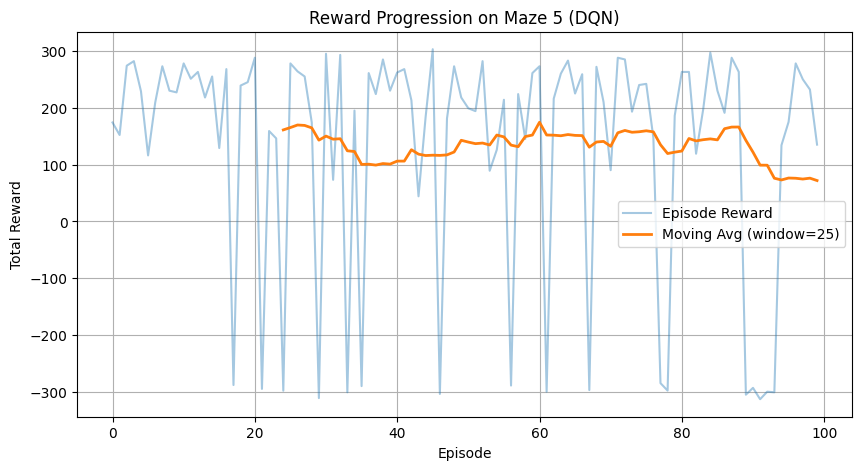

Maze Size 5 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       100
  Mean Reward:    133.55
  Median Reward:  218.30
  Min Reward:     -313.00
  Max Reward:     303.30
  Std Reward:     202.59
  Success Rate:   83.00%

Evaluation (30 episodes):
  Success Rate:   90.00%

Initial maze state:
# # # # #
# A . . #
# # # . #
# . . G #
# # # # #

# # # # #
# S . . #
# # # . #
# . . A #
# # # # #

Final maze state (Total reward: 63.30)
Reached Goal: True


In [ ]:
env = get_env_mazes(mazes_data, "maze")[0][1]
maze_size_dqn = mazes_data[0]["size"]
config_DQN = DQNConfig(maze_size_dqn, env)
agent, reward_history = train_dqn(config_DQN)
plot_rewards(reward_history, maze_size_dqn)
evaluate_agent(agent, maze_size_dqn, reward_history, env)
env.play_agent(agent)

#PPO

##Agent

In [ ]:
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)

In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))

  def forward(self, x):
    return self.net(x)

In [ ]:
class ValueNetwork(nn.Module):
  def __init__(self, state_size, hidden_size):
    super().__init__()

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))

  def forward(self, x):
    return self.net(x)

Proximal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a type of policy gradient method. Instead of calculating Q-values, we train a network $\pi$ to optimize the probability of taking good actions directly, using states as inputs and actions as outputs. PPO also uses a value network $V$ that estimates state values in order to estimate the advantage $\hat{A}$.

Tuples of state, action distribution, action taken, and return $(s,\pi(s), a,\hat{R})$ are gathered for several rollouts. After training on this experience, these tuples are discarded and new experience is gathered.

Loss for the value network and the policy network are calculated according to the following formula:

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-t}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$

Here, $\pi'(a|s)$ is the probability of taking an action given a state under the current policy and $\pi(a|s)$ is the probability of taking an action given a state under the policy used to gather data. In the loss function, $a$ is the action your agent actually took and is sampled from memory.

In [ ]:
class PPOAgent:
    def __init__(self, state_size, action_size=4, hidden_size=16,
                 batch_size=256, gamma=0.99, lr=1e-3,
                 policy_epochs=5, epsilon=.2):

        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_network = PolicyNetwork(state_size, action_size, hidden_size).cuda()
        self.value_network = ValueNetwork(state_size, hidden_size).cuda()

        self.optimizer = optim.AdamW(chain(self.policy_network.parameters(), self.value_network.parameters()), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.95)

    def get_action(self, state):
      with torch.no_grad():
        action_distribution = self.policy_network(torch.from_numpy(state).float().unsqueeze(0).cuda()).squeeze(0)
        selected_action = torch.multinomial(action_distribution, 1).item()
        return selected_action, action_distribution

    def calculate_return(self, memory, rollout):
      running_return = 0
      for i, transition in enumerate(reversed(rollout)): # calculate rollout in reverse
        state, action, action_distribution, reward = transition
        running_return = reward + self.gamma*running_return # add discounted return to new reward for new return
        rollout[len(rollout) - i - 1] = (state, action, action_distribution, running_return)
      memory.extend(rollout) # add rollout to end of memory
      return memory

    def learn_ppo(self, memory):
        policy_losses = []
        value_losses = []
        for epoch in range(self.policy_epochs):
          for state, action, action_distribution, returns in memory:
            state, action, action_distribution, returns = state.float().to(self.device), action.to(self.device), action_distribution.to(self.device), returns.float().to(self.device)

            state_value = self.value_network(state).squeeze()
            value_loss = nn.functional.mse_loss(returns, state_value)

            advantage = returns - state_value
            advantage = advantage.detach()

            current_policy = self.policy_network(state)[torch.arange(state.size(0)), action]

            old_policy = action_distribution[torch.arange(state.size(0)), action]

            policy_ratio = current_policy / old_policy

            policy_grad_loss = policy_ratio * advantage

            clipped_policy_grad_loss = torch.clamp(policy_ratio, 1-self.epsilon, 1+self.epsilon) * advantage

            policy_loss = -torch.mean(torch.min(policy_grad_loss, clipped_policy_grad_loss))

            loss = value_loss + policy_loss

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())

        return np.mean(policy_losses), np.mean(value_losses)

##Training

In [ ]:
def train_ppo_curr(config):
    agent = PPOAgent(
        state_size=config.state_size,
        action_size=config.action_size,
        hidden_size=config.hidden_size,
        batch_size=config.batch_size,
        gamma=config.gamma,
        lr=config.lr,
        policy_epochs=config.policy_epochs,
        epsilon=config.epsilon
    )
    current_env = 0 # Start at smallest env
    maze_size, env = config.mazes[current_env]
    results_ppo = {maze_size:[]}

    # Buffers to track recent performance
    success_buffer = deque(maxlen=30)
    # reward_buffer = deque(maxlen=30)

    loop = tqdm(total=config.episodes, position=0, leave=True)

    for epoch in range(config.episodes):
        memory = []
        rewards = []
        if current_env > 0 and epoch % 10 == 0:
            previous_env = random.choice(config.mazes[:current_env])
            maze_size, env = previous_env
        else:
            maze_size, env = config.mazes[current_env]

        for _ in range(config.env_samples):
            state = env.reset()
            done = False
            rollout = []
            cum_reward, reached_goal = 0, False

            while not done:
                action, action_dist = agent.get_action(state)
                next_state, reward, done, reached_goal = env.step(action)
                rollout.append((state, action, action_dist, reward))
                cum_reward += reward
                state = next_state

            memory = agent.calculate_return(memory, rollout)
            rewards.append((cum_reward, reached_goal))

            success_buffer.append(reached_goal)

        dataset = RLDataset(memory)
        loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
        agent.learn_ppo(loader)
        agent.scheduler.step()

        results_ppo[maze_size].extend(rewards)

        loop.update(1)
        loop.set_description(f"Epoch: {epoch} | Maze: {maze_size} | Reward: {results_ppo[maze_size][-1][0]:.2f} | Goal: {results_ppo[maze_size][-1][1]}")

        # Evaluate current performance
        success_rate = sum(success_buffer) / len(success_buffer)
        min_episodes = 25  # only allow upgrade after this many episodes at current level

        if len(success_buffer) >= min_episodes and success_rate >= 0.9 and current_env + 1 < len(config.mazes):
            print(f"\n Mastered Maze {maze_size} with {success_rate*100:.1f}% success rate over last {len(success_buffer)} episodes!\n")
            current_env += 1
            maze_size, env = config.mazes[current_env]
            results_ppo[maze_size] = []
            success_buffer.clear()
            # reward_buffer.clear()

    return agent, results_ppo


##Single Evaluation

In [ ]:
def run_single_maze(maze_data):
  maze_size = maze_data['size']
  maze_matrix,rows,cols = load_maze_from_txt(f"maze_{maze_size}.txt")
  env = MazeEnv(maze_matrix=maze_matrix, max_steps=maze_data["max_steps"], rewards=maze_data["rewards"])
  config_PPO_Curr = PPOConfigCurriculum([(maze_size,env)],rows)
  agent, rewards = train_ppo_curr(config_PPO_Curr)

  plot_rewards(rewards[maze_size], maze_size, agent_type="ppo")
  evaluate_agent(agent, maze_size, episode_rewards=rewards[maze_size], env=env, n_episodes=30)
  env.play_agent(agent)
  return agent, env

In [ ]:
class PPOConfigCurriculum:
  def __init__(self, mazes, maze_sizes):
    self.mazes = mazes
    self.episodes = 10
    self.env_samples = 10 # 10
    self.epsilon = 0.1
    self.hidden_size = 16 # Larger hidden size seems to be over parametrizing?
    self.policy_epochs = 5
    self.action_size = 4
    self.state_size = 2 * (maze_sizes**2) # This is how it should be, but will hardcode 20 for now
    self.gamma = 0.99
    self.lr = 1e-3
    self.batch_size = 512 # 256

Epoch: 9 | Maze: 15 | Reward: -3941.20 | Goal: False: 100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


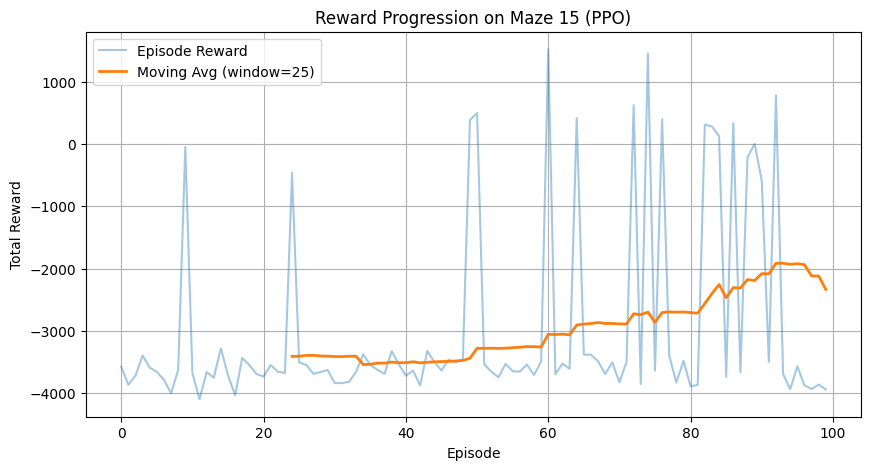

Maze Size 15 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       100
  Mean Reward:    -2971.80
  Median Reward:  -3618.25
  Min Reward:     -4098.70
  Max Reward:     1522.30
  Std Reward:     1525.05
  Success Rate:   17.00%

Evaluation (30 episodes):
  Success Rate:   13.33%

Initial maze state:
# # # # # # # # # # # # # # #
# A . . . # # . . . . . # # #
# # # . # # . . # . # . . # #
# . . . # . . # # # # # . . #
# # . # # . # # . # . # . # #
# . . . . . # . . . . # . . #
# # # # # # # # # . # # # . #
# . . . . . . # # . . . . . #
# . # . # # . . # # . # # # #
# . # . # # # # # . . # . . #
# . # . . . . . # . # # . # #
# . # # # # . # # . # . . . #
# . . . . # . # # . # . # . #
# # . # . # . . . . . . # G #
# # # # # # # # # # # # # # #

# # # # # # # # # # # # # # #
# S . . . # # . . . . . # # #
# # # . # # . . # . # . . # #
# . . . # . . # # # # # . . #
# # . # # . # # . # . # . # #
# . . . . . # . . . . # . . #
# # # # # # # # # . # # # . #
# . . . . . . # # .

In [ ]:
maze_data_15 = {"size":15, "max_steps": 900, "rewards":  [1,-75,-5,4000,.1,-.1,-5]}
agent_15_1, env_15_1 = run_single_maze(maze_data_15)

Epoch: 9 | Maze: 15 | Reward: -2717.20 | Goal: False: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


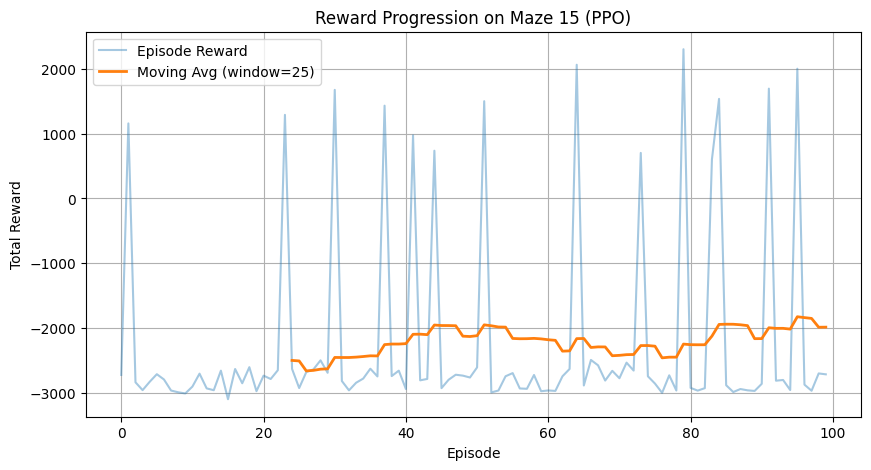

Maze Size 15 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       100
  Mean Reward:    -2224.00
  Median Reward:  -2780.00
  Min Reward:     -3101.70
  Max Reward:     2305.30
  Std Reward:     1482.68
  Success Rate:   14.00%

Evaluation (30 episodes):
  Success Rate:   36.67%

Initial maze state:
# # # # # # # # # # # # # # #
# A . . . # # . . . . . # # #
# # # . # # . . # . # . . # #
# . . . # . . # # # # # . . #
# # . # # . # # . # . # . # #
# . . . . . # . . . . # . . #
# # # # # # # # # . # # # . #
# . . . . . . # # . . . . . #
# . # . # # . . # # . # # # #
# . # . # # # # # . . # . . #
# . # . . . . . # . # # . # #
# . # # # # . # # . # . . . #
# . . . . # . # # . # . # . #
# # . # . # . . . . . . # G #
# # # # # # # # # # # # # # #

# # # # # # # # # # # # # # #
# S . . . # # . . . . . # # #
# # # . # # . . # . # . . # #
# . . . # . . # # # # # . . #
# # . # # . # # . # . # . # #
# . . . . . # . . . . # . . #
# # # # # # # # # . # # # . #
# . . . . . . # # .

In [ ]:
class PPOConfigCurriculum:
  def __init__(self, mazes, maze_sizes):
    self.mazes = mazes
    self.episodes = 10
    self.env_samples = 10 # 10
    self.epsilon = 0.1
    self.hidden_size = 16 # Larger hidden size seems to be over parametrizing?
    self.policy_epochs = 5
    self.action_size = 4
    self.state_size = 2 * (maze_sizes**2) # This is how it should be, but will hardcode 20 for now
    self.gamma = 0.99
    self.lr = 1e-3
    self.batch_size = 512 # 256

maze_data_15_2 = {"size":15, "max_steps": 700, "rewards":  [1,-75,-5,3000,.1,-.1,-5]}
agent_15_2, env_15_2 = run_single_maze(maze_data_15_2)

Epoch: 69 | Maze: 15 | Reward: 3878.30 | Goal: True: 100%|██████████| 70/70 [07:14<00:00,  6.21s/it]


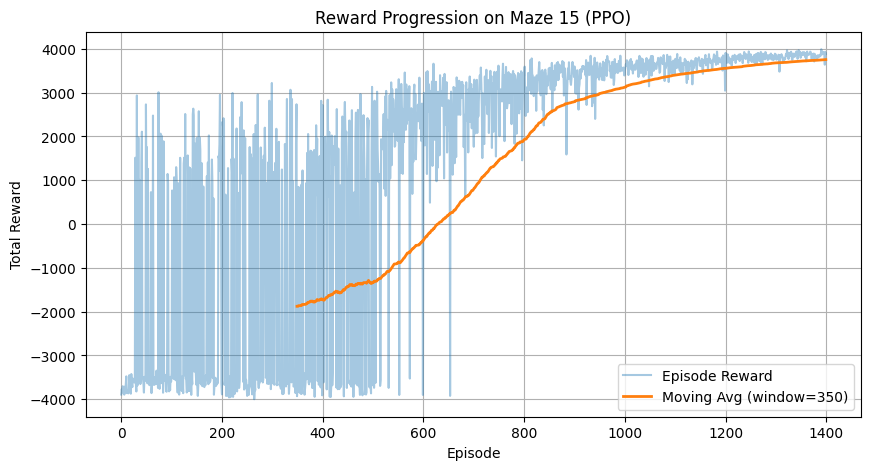

Maze Size 15 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       1400
  Mean Reward:    1485.28
  Median Reward:  2966.80
  Min Reward:     -4000.20
  Max Reward:     3991.30
  Std Reward:     2906.20
  Success Rate:   77.21%

Evaluation (30 episodes):
  Success Rate:   100.00%

Initial maze state:
# # # # # # # # # # # # # # #
# A . . . # # . . . . . # # #
# # # . # # . . # . # . . # #
# . . . # . . # # # # # . . #
# # . # # . # # . # . # . # #
# . . . . . # . . . . # . . #
# # # # # # # # # . # # # . #
# . . . . . . # # . . . . . #
# . # . # # . . # # . # # # #
# . # . # # # # # . . # . . #
# . # . . . . . # . # # . # #
# . # # # # . # # . # . . . #
# . . . . # . # # . # . # . #
# # . # . # . . . . . . # G #
# # # # # # # # # # # # # # #

# # # # # # # # # # # # # # #
# S . . . # # . . . . . # # #
# # # . # # . . # . # . . # #
# . . . # . . # # # # # . . #
# # . # # . # # . # . # . # #
# . . . . . # . . . . # . . #
# # # # # # # # # . # # # . #
# . . . . . . # # .

In [ ]:
class PPOConfigCurriculum:
  def __init__(self, mazes, maze_sizes):
    self.mazes = mazes
    self.episodes = 70
    self.env_samples = 20 # 10
    self.epsilon = 0.1
    self.hidden_size = 16 # Larger hidden size seems to be over parametrizing?
    self.policy_epochs = 5
    self.action_size = 4
    self.state_size = 2 * (maze_sizes**2) # This is how it should be, but will hardcode 20 for now
    self.gamma = 0.99
    self.lr = 1e-3
    self.batch_size = 512 # 256

maze_data_15_3 = {"size":15, "max_steps": 900, "rewards":  [1,-75,-5,4000,.1,-.1,-5]}
agent_15_3, env_15_3 = run_single_maze(maze_data_15_3)

Epoch: 99 | Maze: 20 | Reward: -5293.70 | Goal: False: 100%|██████████| 100/100 [30:33<00:00, 18.33s/it]


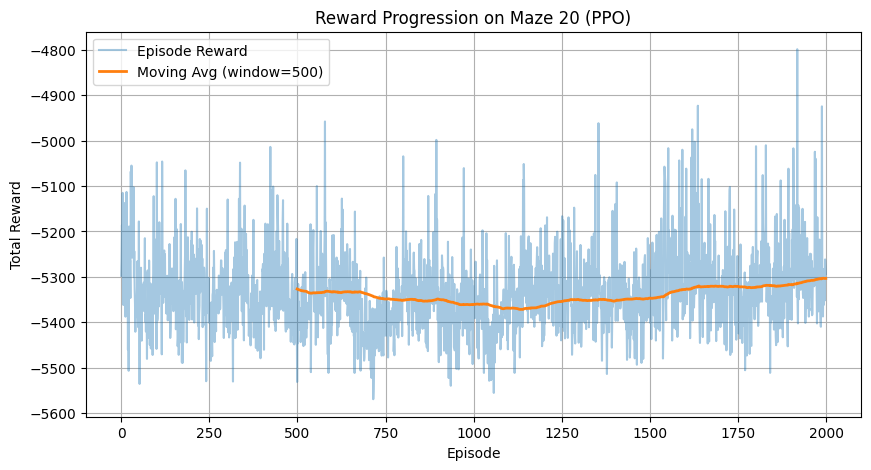

Maze Size 20 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       2000
  Mean Reward:    -5334.64
  Median Reward:  -5344.10
  Min Reward:     -5569.70
  Max Reward:     -4798.60
  Std Reward:     88.16
  Success Rate:   0.00%

Evaluation (30 episodes):
  Success Rate:   0.00%

Initial maze state:
# # # # # # # # # # # # # # # # # # # # #
# A . # # . . . # . . . . . # # . . . . #
# # . . # . # . . . # # . # # . . # . # #
# # # . # # # . # # # . . . # . # # . # #
# . # . . # . . . # # # # . # # # # . . #
# . # # . # # # . . . # . . . . . # # . #
# . . # . . # . . # . # . # . # . . # . #
# . # # # . # # # # . # # # # # # . # . #
# . . . # . . . # # . . # . . # . . # . #
# . # # # # # . . # # . # # . . . # # . #
# . # . . . # # . # . . . # # . # # . . #
# . . . # . . # . # # # . . # . . # # . #
# # # # # # . # . . # # # . # # . . # . #
# . . . . . . # # . # . # . . # # . . . #
# # . # # # # # # . . . # # . . # # # . #
# . . . # . . . # # # . . # # . . # # . #
# . # . . 

In [ ]:
class PPOConfigCurriculum:
  def __init__(self, mazes, maze_sizes):
    self.mazes = mazes
    self.episodes = 100
    self.env_samples = 20 # 10
    self.epsilon = 0.1
    self.hidden_size = 16 # Larger hidden size seems to be over parametrizing?
    self.policy_epochs = 5
    self.action_size = 4
    self.state_size = 2 * (maze_sizes**2) # This is how it should be, but will hardcode 20 for now
    self.gamma = 0.99
    self.lr = 1e-3
    self.batch_size = 512 # 256

maze_data_20_1 = {"size":20, "max_steps": 1500, "rewards":  [1,-150,-5,6000,.1,-.1,-5]}
agent_20_1, env_20_1 = run_single_maze(maze_data_20_1)

##Curriculum Evaluation

In [ ]:
class PPOConfigCurriculum:
  def __init__(self, mazes, maze_sizes):
    self.mazes = mazes
    self.episodes = 150
    self.env_samples = 20 # 10
    self.epsilon = 0.1
    self.hidden_size = 16 # Larger hidden size seems to be over parametrizing?
    self.policy_epochs = 5
    self.action_size = 4
    self.state_size = 2 * (maze_sizes**2) # This is how it should be, but will hardcode 20 for now
    self.gamma = 0.99
    self.lr = 1e-3
    self.batch_size = 512 # 256

mazes_data = [
    {"size":5,  "max_steps": 75,  "rewards":  [1,-10,-5,300,.1,-.1,-5]},  # 0: move, 1: timeout, 2: hit wall, 3: goal, 4: bonus for progress 5: going wrong direction, 6: repeating cell
    {"size":7,  "max_steps": 100, "rewards":  [1,-20,-5,500,.1,-.1,-5]},
    {"size":9,  "max_steps": 200, "rewards":  [1,-35,-5,750,.1,-.1,-5]},
    {"size":11, "max_steps": 600, "rewards":  [1,-50,-5,1300,.1,-.1,-5]},
    {"size":15, "max_steps": 900, "rewards":  [1,-75,-5,2750,.1,-.1,-5]},
    {"size":20, "max_steps": 1400, "rewards": [1,-150,-5,4500,.1,-.1,-5]}
]


In [ ]:
mazes_config = get_env_mazes(mazes_data)
config_PPO_Curr = PPOConfigCurriculum(mazes_config,21) # 21 because of the padding
agent, rewards = train_ppo_curr(config_PPO_Curr)

Epoch: 4 | Maze: 5 | Reward: 222.30 | Goal: True:   3%|▎         | 5/150 [00:03<01:26,  1.67it/s]


✅ Mastered Maze 5 with 93.3% success rate over last 30 episodes!



Epoch: 6 | Maze: 7 | Reward: 313.70 | Goal: True:   5%|▍         | 7/150 [00:05<01:55,  1.23it/s]  


✅ Mastered Maze 7 with 96.7% success rate over last 30 episodes!



Epoch: 10 | Maze: 7 | Reward: 464.70 | Goal: True:   7%|▋         | 11/150 [00:10<02:17,  1.01it/s]


✅ Mastered Maze 7 with 96.7% success rate over last 30 episodes!



Epoch: 13 | Maze: 11 | Reward: 571.50 | Goal: True:   9%|▉         | 14/150 [00:24<07:42,  3.40s/it] 


✅ Mastered Maze 11 with 93.3% success rate over last 30 episodes!



Epoch: 149 | Maze: 15 | Reward: -3631.60 | Goal: False: 100%|██████████| 150/150 [27:08<00:00, 10.86s/it]


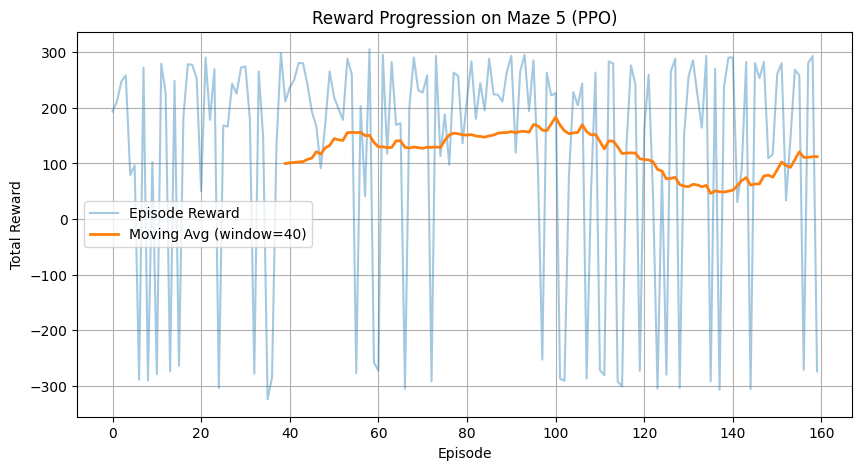

Maze Size 5 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       160
  Mean Reward:    117.93
  Median Reward:  211.30
  Min Reward:     -324.00
  Max Reward:     305.30
  Std Reward:     208.35
  Success Rate:   80.62%

Evaluation (30 episodes):
  Success Rate:   63.33%

Initial maze state:
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P # # # # # P P P P P P P P
P P P P P P P P # A . . # P P P P P P P P
P P P P P P P P # . # # # P P P P P P P P
P P P P P P P P # . . G # P P P P P P P P
P P P P P P P P # # # # # P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P 

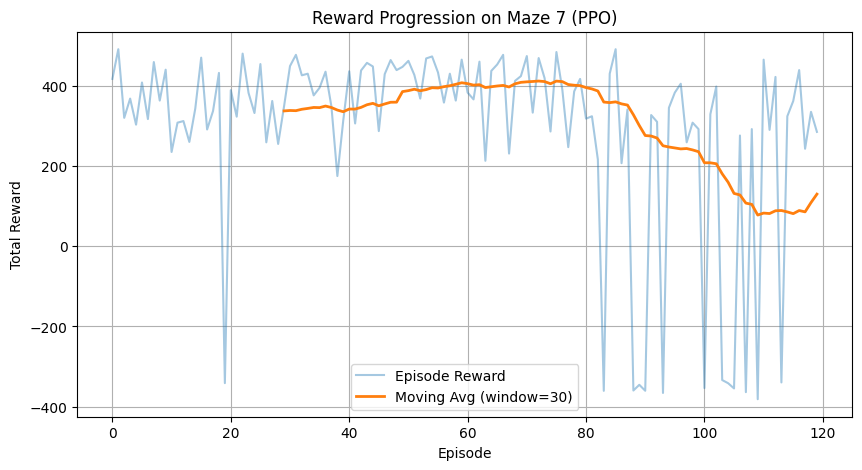

Maze Size 7 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       120
  Mean Reward:    293.55
  Median Reward:  362.20
  Min Reward:     -381.40
  Max Reward:     490.70
  Std Reward:     237.22
  Success Rate:   89.17%

Evaluation (30 episodes):
  Success Rate:   86.67%

Initial maze state:
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P # # # # # # # P P P P P P P
P P P P P P P # A . . # . # P P P P P P P
P P P P P P P # # # . # . # P P P P P P P
P P P P P P P # . # . . . # P P P P P P P
P P P P P P P # . # # # . # P P P P P P P
P P P P P P P # . . . . G # P P P P P P P
P P P P P P P # # # # # # # P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P 

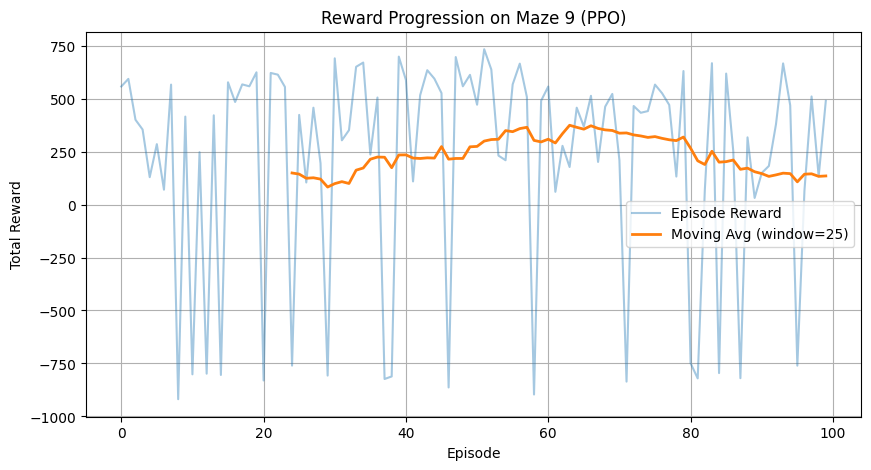

Maze Size 9 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       100
  Mean Reward:    218.32
  Median Reward:  428.10
  Min Reward:     -918.90
  Max Reward:     733.10
  Std Reward:     500.25
  Success Rate:   83.00%

Evaluation (30 episodes):
  Success Rate:   60.00%

Initial maze state:
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P # # # # # # # # # P P P P P P
P P P P P P # A . . # # . . # P P P P P P
P P P P P P # . # . # . . # # P P P P P P
P P P P P P # # # . # . # # # P P P P P P
P P P P P P # # . . # . . . # P P P P P P
P P P P P P # . . # # # # . # P P P P P P
P P P P P P # # . . . # # . # P P P P P P
P P P P P P # . . # . . . G # P P P P P P
P P P P P P # # # # # # # # # P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P 

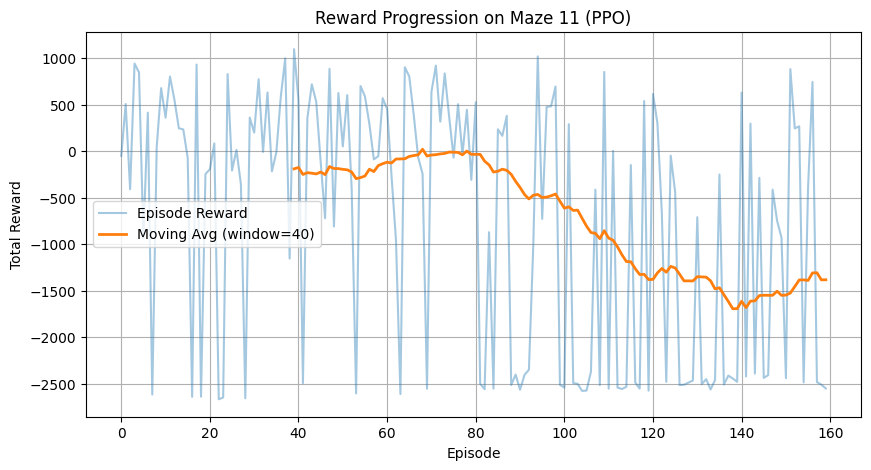

Maze Size 11 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       160
  Mean Reward:    -745.38
  Median Reward:  -229.00
  Min Reward:     -2665.20
  Max Reward:     1097.50
  Std Reward:     1352.81
  Success Rate:   65.62%

Evaluation (30 episodes):
  Success Rate:   63.33%

Initial maze state:
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P # # # # # # # # # # # P P P P P
P P P P P # A . . # . . . . . # P P P P P
P P P P P # . # . # # # # # . # P P P P P
P P P P P # # # . . # # . . . # P P P P P
P P P P P # . # # . . # . # . # P P P P P
P P P P P # . # # # . # . # # # P P P P P
P P P P P # . # . . . # . . . # P P P P P
P P P P P # . . . # # # # # . # P P P P P
P P P P P # . # # # . # . . . # P P P P P
P P P P P # . . . . . . . # G # P P P P P
P P P P P # # # # # # # # # # # P P P P P
P P P P P 

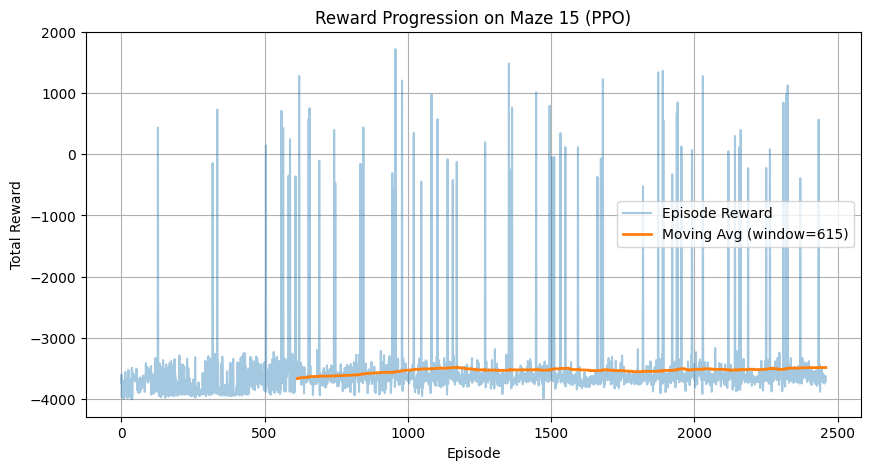

Maze Size 15 Agent Evaluation:

Evaluation from Training Episodes:
  Episodes:       2460
  Mean Reward:    -3554.43
  Median Reward:  -3654.60
  Min Reward:     -4005.20
  Max Reward:     1719.30
  Std Reward:     658.34
  Success Rate:   2.60%

Evaluation (30 episodes):
  Success Rate:   0.00%

Initial maze state:
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P P P P P P P P P P P P P P P P P P P
P P P # # # # # # # # # # # # # # # P P P
P P P # A . # # # # # . . . # . . # P P P
P P P # # . . # # # . . # . . . # # P P P
P P P # # # . . # . . # # # # . . # P P P
P P P # . # # . . . # # . . # # . # P P P
P P P # . . # # # # # # . # # . . # P P P
P P P # # . . # . # . # . . . . # # P P P
P P P # # # . # . . . . . # # # # # P P P
P P P # . # . . . # # # # # # . . # P P P
P P P # . # . # # # # . . . . . # # P P P
P P P # . # . . . . # # . # # . . # P P P
P P P # . # # # # . # # . # # # . # P P P
P P P # . . # . . . . . . # . . . # P P P
P P P # # 

In [ ]:
for maze_size, env in mazes_config:
    if maze_size not in rewards:
      continue
    plot_rewards(rewards[maze_size], maze_size, agent_type="ppo")
    evaluate_agent(agent, maze_size, episode_rewards=rewards[maze_size], env=env, n_episodes=30)
    env.play_agent(agent)
